In [1]:
import pandas as pd

df = pd.read_csv('raw\\train.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710670 entries, 0 to 1710669
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   TRIP_ID       int64  
 1   CALL_TYPE     object 
 2   ORIGIN_CALL   float64
 3   ORIGIN_STAND  float64
 4   TAXI_ID       int64  
 5   TIMESTAMP     int64  
 6   DAY_TYPE      object 
 7   MISSING_DATA  bool   
 8   POLYLINE      object 
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 106.0+ MB


In [3]:
taxi_ids = df['TAXI_ID'].unique()
print(len(taxi_ids))

448


In [4]:
missing_data_counts = df['MISSING_DATA'].value_counts()
print("Number of records with MISSING_DATA = True:", missing_data_counts.get(True, 0))
print("Number of records with MISSING_DATA = False:", missing_data_counts.get(False, 0))

Number of records with MISSING_DATA = True: 10
Number of records with MISSING_DATA = False: 1710660


In [5]:
df_clean = df[df['MISSING_DATA'] == False].copy()
df_clean.reset_index(drop=True, inplace=True)

In [6]:
missing_data_counts = df_clean['MISSING_DATA'].value_counts()
print("Number of records with MISSING_DATA = True:", missing_data_counts.get(True, 0))
print("Number of records with MISSING_DATA = False:", missing_data_counts.get(False, 0))

Number of records with MISSING_DATA = True: 0
Number of records with MISSING_DATA = False: 1710660


In [7]:
taxi_dfs = {taxi_id: df_clean[df_clean['TAXI_ID'] == taxi_id] for taxi_id in taxi_ids}
print(len(taxi_dfs))
for taxi_id, taxi_df in taxi_dfs.items():
    print(f'Taxi ID: {taxi_id}, Number of records: {len(taxi_df)}')
print("Total number of entries:", sum(len(taxi_df) for taxi_df in taxi_dfs.values()))

448
Taxi ID: 20000589, Number of records: 4744
Taxi ID: 20000596, Number of records: 3978
Taxi ID: 20000320, Number of records: 6146
Taxi ID: 20000520, Number of records: 4960
Taxi ID: 20000337, Number of records: 5731
Taxi ID: 20000231, Number of records: 3056
Taxi ID: 20000456, Number of records: 2131
Taxi ID: 20000011, Number of records: 5963
Taxi ID: 20000403, Number of records: 9238
Taxi ID: 20000233, Number of records: 6313
Taxi ID: 20000571, Number of records: 4201
Taxi ID: 20000497, Number of records: 4177
Taxi ID: 20000570, Number of records: 3883
Taxi ID: 20000005, Number of records: 6093
Taxi ID: 20000089, Number of records: 7267
Taxi ID: 20000423, Number of records: 5147
Taxi ID: 20000657, Number of records: 4562
Taxi ID: 20000309, Number of records: 3942
Taxi ID: 20000161, Number of records: 3930
Taxi ID: 20000178, Number of records: 3236
Taxi ID: 20000235, Number of records: 6410
Taxi ID: 20000653, Number of records: 6070
Taxi ID: 20000009, Number of records: 4775
Taxi ID

In [8]:
import ast

def process_polyline(polyline, timestamp):
    coords = ast.literal_eval(polyline)
    delta_seconds = 15
    data = []
    for i, (lon, lat) in enumerate(coords):
        data.append({'latitude': lat, 'longitude': lon, 'timestamp': timestamp + i * delta_seconds})
    trajectory_df = pd.DataFrame(data)
    return trajectory_df
    
    

In [10]:
processed_data = {}
for taxi_id, taxi_df in taxi_dfs.items():
    processed_data[taxi_id] = {}
    for _, row in taxi_df.iterrows():
        timestamp = int(row['TIMESTAMP'])
        polyline = str(row['POLYLINE'])
        tripid = str(row['TRIP_ID'])
        trajectory = process_polyline(polyline, timestamp)

        processed_data[taxi_id][tripid] = trajectory

In [11]:
import pickle

with open('processed/porto_data.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

In [1]:
import pickle

with open('processed/porto_data.pkl', 'rb') as f:
    processed_data = pickle.load(f)

In [2]:
import folium

# Center the map on Porto
m = folium.Map(location=[41.15, -8.61], zoom_start=12, tiles='cartodbpositron')

for taxi_id in list(processed_data.keys())[:1]:
    print(taxi_id)
    trips = processed_data[taxi_id]
    for i, (trip_id, traj) in enumerate(trips.items()):
        print(trip_id)
        if i >= 4:
            break
        if not traj.empty:
            points = traj[['latitude', 'longitude']].values.tolist()
            folium.PolyLine(points, color='blue', weight=2, opacity=0.2).add_to(m)

m

20000589
1372636858620000589
1372637345620000589
1372661951620000589
1372667894620000589
1372670054620000589


In [3]:
m = folium.Map(location=[41.15, -8.61], zoom_start=12, tiles='cartodbpositron')
traj = processed_data[20000589]['1372667894620000589']
points = traj[['latitude', 'longitude']].values.tolist()
folium.PolyLine(points, color='blue', weight=2, opacity=0.2).add_to(m)
m

In [4]:
from geopy.distance import geodesic

traj = processed_data[20000589]['1372667894620000589']
distances = [0.0]
for i in range(1, len(traj)):
    prev_point = (traj.iloc[i-1]['latitude'], traj.iloc[i-1]['longitude'])
    curr_point = (traj.iloc[i]['latitude'], traj.iloc[i]['longitude'])
    distances.append(geodesic(prev_point, curr_point).meters)

traj_with_dist = traj.copy()
traj_with_dist['distance_diff'] = distances
print(traj_with_dist)

     latitude  longitude   timestamp  distance_diff
0   41.154102  -8.649342  1372667894       0.000000
1   41.154201  -8.649936  1372667909      51.057515
2   41.153769  -8.650485  1372667924      66.523328
3   41.153283  -8.650971  1372667939      67.656185
4   41.152581  -8.651763  1372667954     102.458571
5   41.152257  -8.653365  1372667969     139.204459
6   41.152212  -8.655048  1372667984     141.361582
7   41.151627  -8.656290  1372667999     122.841784
8   41.151033  -8.657784  1372668014     141.701875
9   41.150790  -8.659431  1372668029     140.863359
10  41.150673  -8.660088  1372668044      56.660693
11  41.150457  -8.661213  1372668059      97.435434
12  41.150475  -8.661483  1372668074      22.752747
13  41.150484  -8.661483  1372668089       0.999511
14  41.150484  -8.661492  1372668104       0.755492
15  41.150502  -8.662608  1372668119      93.702300
16  41.150718  -8.664903  1372668134     194.137781
17  41.151609  -8.667648  1372668149     250.770840
18  41.15269

In [5]:
import pickle

with open('processed/porto_data_cleaned.pkl', 'rb') as f:
    clean_data = pickle.load(f)

In [ ]:
print(len(clean_data))

count = 0
for taxi_id, trips in clean_data.items():
    count += len(trips)
print(count)

448
1710579


In [8]:
import folium

# Center the map on Porto
m = folium.Map(location=[41.15, -8.61], zoom_start=12, tiles='cartodbpositron')

for taxi_id in list(clean_data.keys())[:1]:
    trips = clean_data[taxi_id]
    for i, (trip_id, traj) in enumerate(trips.items()):
        if i >= 4:
            break
        if not traj.empty:
            points = traj[['latitude', 'longitude']].values.tolist()
            folium.PolyLine(points, color='blue', weight=2, opacity=0.2).add_to(m)

m

In [9]:
# Filter out trajectories with less than 3 entries
filtered_clean_data = {}
for taxi_id, trips in clean_data.items():
    filtered_trips = {}
    for trip_id, traj in trips.items():
        if len(traj) >= 3:
            filtered_trips[trip_id] = traj
    if filtered_trips:  # Only add taxi if it has at least one valid trip
        filtered_clean_data[taxi_id] = filtered_trips

clean_data = filtered_clean_data

In [14]:
print(len(filtered_clean_data))

count = 0
for taxi_id, trips in filtered_clean_data.items():
    count += len(trips)
print(count)

442
1666247


In [16]:
# Center the map on Porto
m = folium.Map(location=[41.15, -8.61], zoom_start=12, tiles='cartodbpositron')

for taxi_id in list(filtered_clean_data.keys())[:10]:
    trips = filtered_clean_data[taxi_id]
    for i, (trip_id, traj) in enumerate(trips.items()):
        if i >= 10:
            break
        points = traj[['latitude', 'longitude']].values.tolist()
        folium.PolyLine(points, color='blue', weight=2, opacity=0.2).add_to(m)

m

In [15]:
import pickle

with open('processed/porto_filtered_clean_data.pkl', 'wb') as f:
    pickle.dump(filtered_clean_data, f)

In [1]:
import pickle

with open('processed/porto_filtered_clean_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
import pandas as pd

start_points = []
end_points = []

for taxi_id, trips in data.items():
    for trip_id, traj in trips.items():
        start_row = traj.iloc[0]
        start_points.append({
            'latitude': start_row['latitude'],
            'longitude': start_row['longitude']
        })
        
        end_row = traj.iloc[-1]
        end_points.append({
            'latitude': end_row['latitude'],
            'longitude': end_row['longitude']
        })

start_points_df = pd.DataFrame(start_points)
end_points_df = pd.DataFrame(end_points)

start_points_df.to_csv('processed/porto_start_points.csv', index=False)
end_points_df.to_csv('processed/porto_end_points.csv', index=False)

In [4]:
import numpy as np

start_latitudes = start_points_df['latitude'].values
start_longitudes = start_points_df['longitude'].values

MIN_START_LAT = np.min(start_latitudes)
MAX_START_LAT = np.max(start_latitudes)
MIN_START_LON = np.min(start_longitudes)
MAX_START_LON = np.max(start_longitudes)

print(f"Start points latitude range: {MIN_START_LAT:.6f} to {MAX_START_LAT:.6f}")
print(f"Start points longitude range: {MIN_START_LON:.6f} to {MAX_START_LON:.6f}")


Start points latitude range: 37.184832 to 42.078276
Start points longitude range: -9.378459 to -6.273549


In [5]:
import numpy as np

end_latitudes = end_points_df['latitude'].values
end_longitudes = end_points_df['longitude'].values

MIN_END_LAT = np.min(end_latitudes)
MAX_END_LAT = np.max(end_latitudes)
MIN_END_LON = np.min(end_longitudes)
MAX_END_LON = np.max(end_longitudes)

print(f"End points latitude range: {MIN_END_LAT:.6f} to {MAX_END_LAT:.6f}")
print(f"End points longitude range: {MIN_END_LON:.6f} to {MAX_END_LON:.6f}")

End points latitude range: 38.534130 to 42.151023
End points longitude range: -9.442458 to -6.263919


Running elbow method analysis...
Testing k=100
Testing k=200
Testing k=300
Testing k=400
Testing k=500
Testing k=600
Testing k=700
Testing k=800
Testing k=900
Testing k=1000


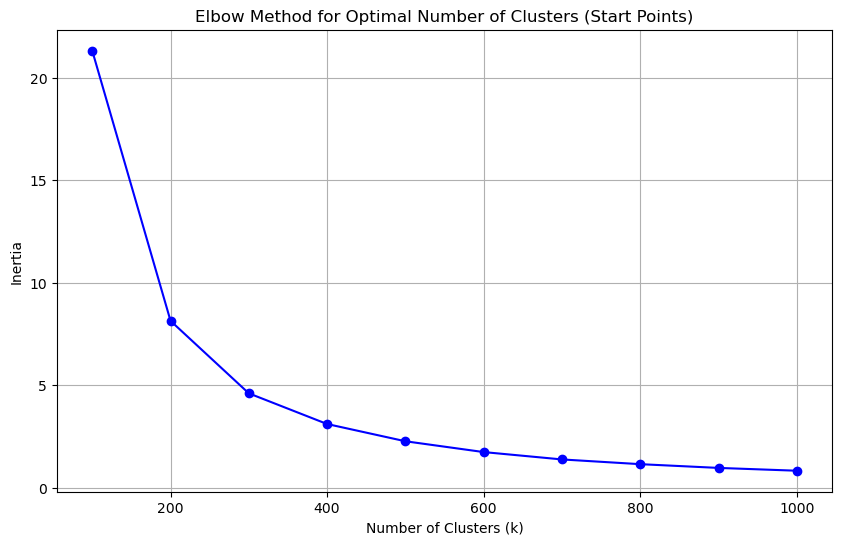

k=100: inertia=21.32
k=200: inertia=8.14
k=300: inertia=4.60
k=400: inertia=3.10
k=500: inertia=2.26
k=600: inertia=1.73
k=700: inertia=1.37
k=800: inertia=1.14
k=900: inertia=0.96
k=1000: inertia=0.82


In [7]:
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

X = start_points_df[['latitude', 'longitude']].values

k_range = range(10, 110, 10)
inertias = []

print("Running elbow method analysis...")
for k in k_range:
    print(f"Testing k={k}")
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    
    centroids_df = pd.DataFrame(kmeans.cluster_centers_, columns=['latitude', 'longitude'])
    centroids_df.to_csv(f'processed/start_points_centroids_k{k}.csv', index=False)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters (Start Points)')
plt.grid(True)
plt.show()

# Print the inertia values
for k, inertia in zip(k_range, inertias):
    print(f"k={k}: inertia={inertia:.2f}")

# k=100: inertia=21.32
# k=200: inertia=8.14
# k=300: inertia=4.60
# k=400: inertia=3.10
# k=500: inertia=2.26
# k=600: inertia=1.73
# k=700: inertia=1.37
# k=800: inertia=1.14
# k=900: inertia=0.96
# k=1000: inertia=0.82

Running elbow method analysis...
Testing k=100
Testing k=200
Testing k=300
Testing k=400
Testing k=500
Testing k=600
Testing k=700
Testing k=800
Testing k=900
Testing k=1000


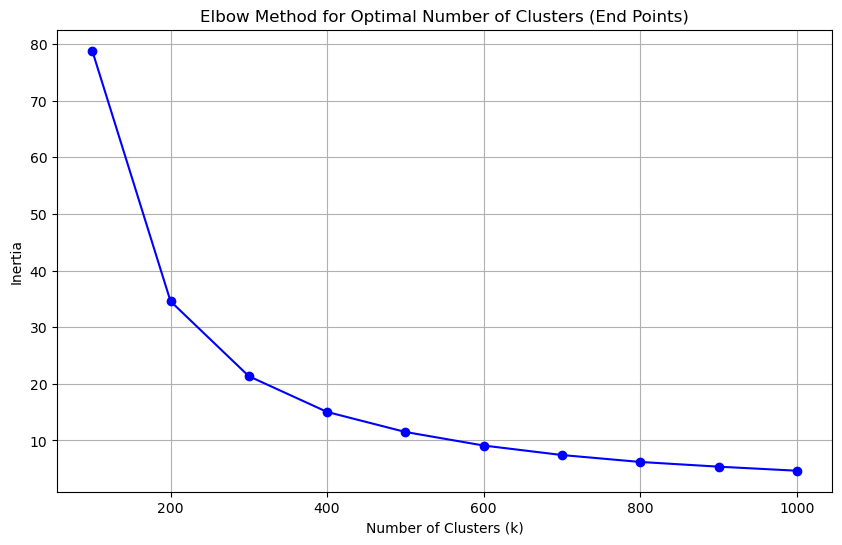

k=100: inertia=78.83
k=200: inertia=34.58
k=300: inertia=21.35
k=400: inertia=15.04
k=500: inertia=11.50
k=600: inertia=9.10
k=700: inertia=7.43
k=800: inertia=6.20
k=900: inertia=5.37
k=1000: inertia=4.66


In [8]:
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

X = end_points_df[['latitude', 'longitude']].values

k_range = range(100, 1100, 100)
inertias = []

print("Running elbow method analysis...")
for k in k_range:
    print(f"Testing k={k}")
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    
    centroids_df = pd.DataFrame(kmeans.cluster_centers_, columns=['latitude', 'longitude'])
    centroids_df.to_csv(f'processed/end_points_centroids_k{k}.csv', index=False)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters (End Points)')
plt.grid(True)
plt.show()

# Print the inertia values
for k, inertia in zip(k_range, inertias):
    print(f"k={k}: inertia={inertia:.2f}")

# k=100: inertia=78.83
# k=200: inertia=34.58
# k=300: inertia=21.35
# k=400: inertia=15.04
# k=500: inertia=11.50
# k=600: inertia=9.10
# k=700: inertia=7.43
# k=800: inertia=6.20
# k=900: inertia=5.37
# k=1000: inertia=4.66

In [9]:
import folium

start_centroids = pd.read_csv('processed/start_points_centroids_k300.csv')
end_centroids = pd.read_csv('processed/end_points_centroids_k300.csv')

m = folium.Map(location=[41.15, -8.61], zoom_start=12, tiles='cartodbpositron')

for _, row in start_centroids.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color='green',
        fill=True,
        fillColor='green',
        fillOpacity=0.7,
        popup=f'Start Centroid'
    ).add_to(m)

for _, row in end_centroids.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color='red',
        fill=True,
        fillColor='red',
        fillOpacity=0.7,
        popup=f'End Centroid'
    ).add_to(m)

m

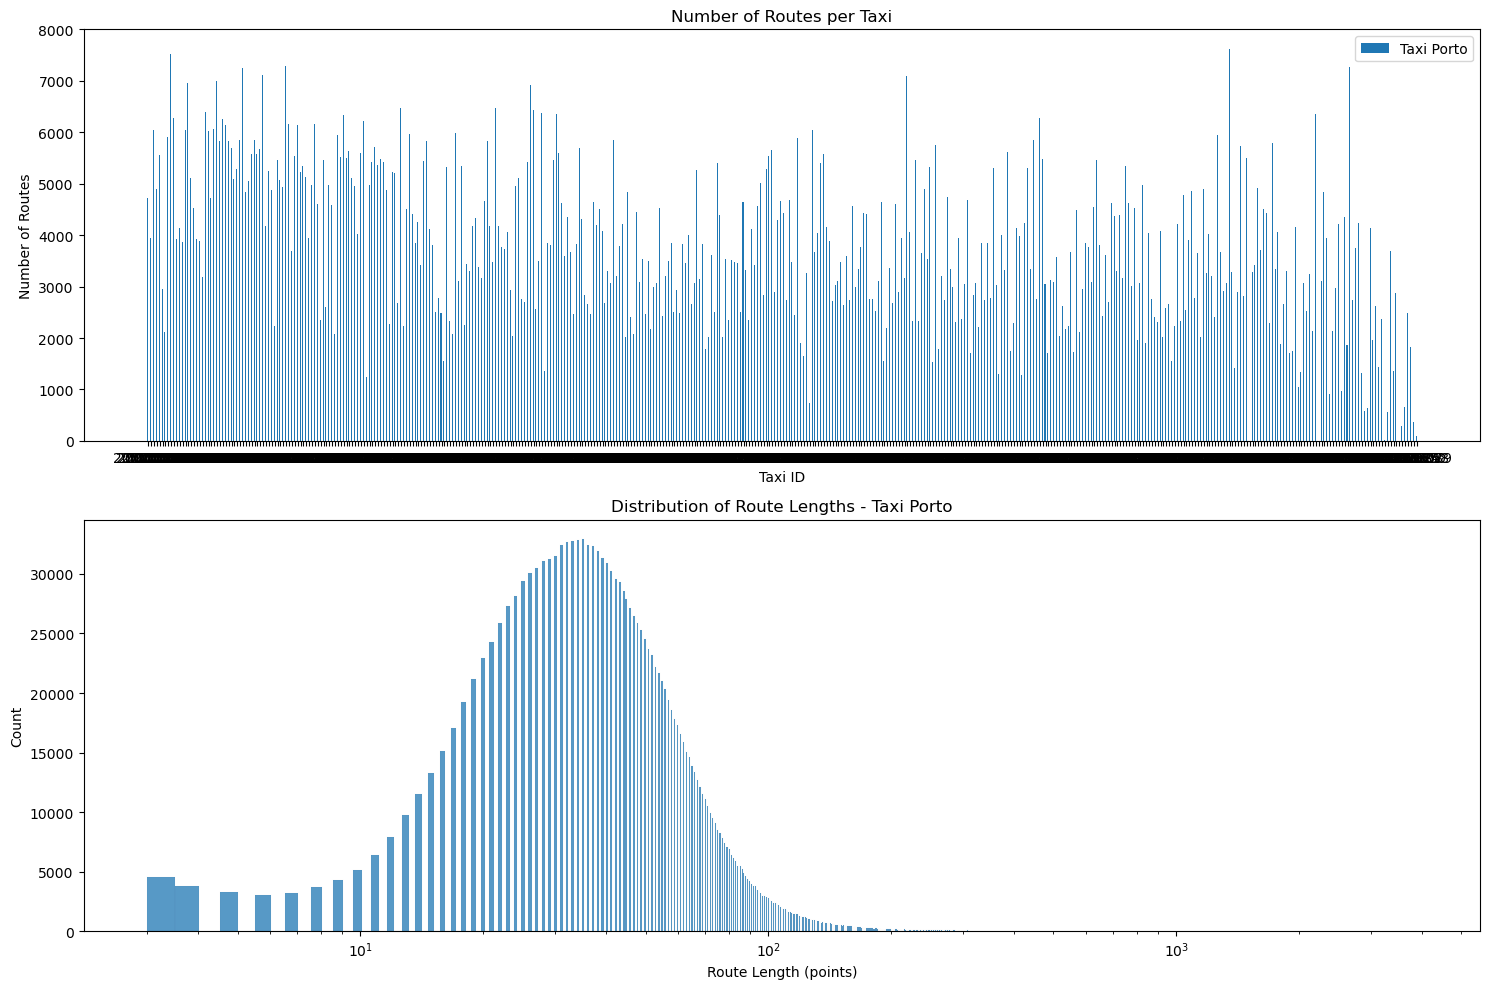

Taxi Porto total routes: 1666247
Taxi Porto avg route length: 49.98445788649582


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

taxi_routes = {taxi_id: len(dataframes) for taxi_id, dataframes in data.items()}

taxi_route_lengths = {}
for taxi_id, dataframes in data.items():
    taxi_route_lengths[taxi_id] = [len(df) for _, df in dataframes.items()]


plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
# participant_ids = list(original_routes_count.keys())[:10]  # Limit to 10 participants for clarity
participant_ids = list(taxi_routes.keys())
org_counts = [taxi_routes[p] for p in participant_ids]

x = np.arange(len(participant_ids))
width = 0.35

plt.bar(x - width/2, org_counts, width, label='Taxi Porto')
plt.xlabel('Taxi ID')
plt.ylabel('Number of Routes')
plt.title('Number of Routes per Taxi')
plt.xticks(x, participant_ids)
plt.legend()



plt.subplot(2, 1, 2)
all_taxi_lengths = [length for p_lengths in taxi_route_lengths.values() for length in p_lengths]
sns.histplot(all_taxi_lengths)
plt.xlabel('Route Length (points)')
plt.ylabel('Count')
plt.title('Distribution of Route Lengths - Taxi Porto')
plt.xscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.show()


print("Taxi Porto total routes:", sum(taxi_routes.values()))
print("Taxi Porto avg route length:", np.mean(all_taxi_lengths))

In [13]:
import pickle

with open('processed/porto_filtered_clean_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [14]:
first_10_taxis = {}
taxi_ids = list(data.keys())[:10]

for taxi_id in taxi_ids:
    first_10_taxis[taxi_id] = data[taxi_id]

print("First 10 taxi IDs:", taxi_ids)
print("Number of taxis:", len(first_10_taxis))

for taxi_id in taxi_ids:
    print(f"Taxi {taxi_id}: {len(first_10_taxis[taxi_id])} trips")

First 10 taxi IDs: [20000589, 20000596, 20000320, 20000520, 20000337, 20000231, 20000456, 20000011, 20000403, 20000233]
Number of taxis: 10
Taxi 20000589: 4722 trips
Taxi 20000596: 3946 trips
Taxi 20000320: 6043 trips
Taxi 20000520: 4888 trips
Taxi 20000337: 5558 trips
Taxi 20000231: 2949 trips
Taxi 20000456: 2114 trips
Taxi 20000011: 5916 trips
Taxi 20000403: 7512 trips
Taxi 20000233: 6268 trips


In [15]:
import datetime

data_with_metadata = {}

for taxi_id, trips in first_10_taxis.items():
    data_with_metadata[taxi_id] = {}
    
    for trip_id, trip_df in trips.items():
        first_timestamp = trip_df.iloc[0]['timestamp']
        dt = datetime.datetime.fromtimestamp(first_timestamp)
        
        month = dt.month
        day_of_week = dt.weekday()
        hour = dt.hour
        
        data_with_metadata[taxi_id][trip_id] = {
            'df': trip_df,
            'metadata': {
                'month': month,
                'day_of_week': day_of_week,
                'hour': hour
            }
        }


print("Sample trip metadata:")
sample_taxi = list(data_with_metadata.keys())[0]
sample_trip = list(data_with_metadata[sample_taxi].keys())[0]
print(f"Taxi {sample_taxi}, Trip {sample_trip}:")
print(f"Metadata: {data_with_metadata[sample_taxi][sample_trip]['metadata']}")
print(f"DataFrame shape: {data_with_metadata[sample_taxi][sample_trip]['df'].shape}")

Sample trip metadata:
Taxi 20000589, Trip 1372636858620000589:
Metadata: {'month': 7, 'day_of_week': 0, 'hour': 3}
DataFrame shape: (23, 3)


In [16]:
data_with_metadata_and_delta = {}

for taxi_id, trips in data_with_metadata.items():
    data_with_metadata_and_delta[taxi_id] = {}
    
    for trip_id, trip_data in trips.items():
        trip_df = trip_data['df'].copy()
        
        delta_times = [0.0]
        for i in range(1, len(trip_df)):
            prev_timestamp = trip_df.iloc[i-1]['timestamp']
            curr_timestamp = trip_df.iloc[i]['timestamp']
            delta_times.append(curr_timestamp - prev_timestamp)
        
        trip_df['delta_time'] = delta_times
        
        data_with_metadata_and_delta[taxi_id][trip_id] = {
            'df': trip_df,
            'metadata': trip_data['metadata']
        }

print("Sample trip with delta time:")
sample_taxi = list(data_with_metadata_and_delta.keys())[0]
sample_trip = list(data_with_metadata_and_delta[sample_taxi].keys())[0]
print(f"Taxi {sample_taxi}, Trip {sample_trip}:")
print(data_with_metadata_and_delta[sample_taxi][sample_trip]['df'].head())

Sample trip with delta time:
Taxi 20000589, Trip 1372636858620000589:
    latitude  longitude   timestamp  delta_time
0  41.141412  -8.618643  1372636858         0.0
1  41.141376  -8.618499  1372636873        15.0
2  41.142510  -8.620326  1372636888        15.0
3  41.143815  -8.622153  1372636903        15.0
4  41.144373  -8.623953  1372636918        15.0


In [17]:
from sklearn.neighbors import NearestNeighbors

start_centroids = pd.read_csv('processed/start_points_centroids_k300.csv')

nn_model = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn_model.fit(start_centroids[['latitude', 'longitude']].values)

for taxi_id, trips in data_with_metadata_and_delta.items():
    for trip_id, trip_data in trips.items():

        first_point = trip_data['df'].iloc[0]
        start_lat, start_lon = first_point['latitude'], first_point['longitude']
        
        _, indices = nn_model.kneighbors([[start_lat, start_lon]])
        closest_centroid_idx = indices[0][0]
        
        trip_data['metadata']['start_centroid_idx'] = closest_centroid_idx

print("Sample trip metadata with centroid index:")
sample_taxi = list(data_with_metadata_and_delta.keys())[0]
sample_trip = list(data_with_metadata_and_delta[sample_taxi].keys())[0]
print(f"Taxi {sample_taxi}, Trip {sample_trip}:")
print(f"Metadata: {data_with_metadata_and_delta[sample_taxi][sample_trip]['metadata']}")

Sample trip metadata with centroid index:
Taxi 20000589, Trip 1372636858620000589:
Metadata: {'month': 7, 'day_of_week': 0, 'hour': 3, 'start_centroid_idx': 159}


In [18]:
end_centroids = pd.read_csv('processed/end_points_centroids_k300.csv')

end_nn_model = NearestNeighbors(n_neighbors=1, metric='euclidean')
end_nn_model.fit(end_centroids[['latitude', 'longitude']].values)

for taxi_id, trips in data_with_metadata_and_delta.items():
    for trip_id, trip_data in trips.items():
        last_point = trip_data['df'].iloc[-1]
        end_lat, end_lon = last_point['latitude'], last_point['longitude']
        
        _, indices = end_nn_model.kneighbors([[end_lat, end_lon]])
        closest_end_centroid_idx = indices[0][0]
        
        centroid_lat = end_centroids.iloc[closest_end_centroid_idx]['latitude']
        centroid_lon = end_centroids.iloc[closest_end_centroid_idx]['longitude']
        
        delta_lat = end_lat - centroid_lat
        delta_lon = end_lon - centroid_lon
        
        trip_data['metadata']['y_centroid_idx'] = closest_end_centroid_idx
        trip_data['metadata']['y_delta_lat'] = delta_lat
        trip_data['metadata']['y_delta_lon'] = delta_lon

print("Sample trip metadata with end centroid info:")
sample_taxi = list(data_with_metadata_and_delta.keys())[0]
sample_trip = list(data_with_metadata_and_delta[sample_taxi].keys())[0]
print(f"Taxi {sample_taxi}, Trip {sample_trip}:")
print(f"Metadata: {data_with_metadata_and_delta[sample_taxi][sample_trip]['metadata']}")

Sample trip metadata with end centroid info:
Taxi 20000589, Trip 1372636858620000589:
Metadata: {'month': 7, 'day_of_week': 0, 'hour': 3, 'start_centroid_idx': 159, 'y_centroid_idx': 21, 'y_delta_lat': 0.00046723826014272163, 'y_delta_lon': -0.00020776392159582713}


In [19]:
import pickle

with open('processed/porto_filtered_clean_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [22]:
start_centroids = pd.read_csv('processed/start_points_centroids_k300.csv')
start_nn_model = NearestNeighbors(n_neighbors=1, metric='euclidean')
start_nn_model.fit(start_centroids[['latitude', 'longitude']].values)

end_centroids = pd.read_csv('processed/end_points_centroids_k300.csv')
end_nn_model = NearestNeighbors(n_neighbors=1, metric='euclidean')
end_nn_model.fit(end_centroids[['latitude', 'longitude']].values)

data_with_metadata = {}

for taxi_id, trips in data.items():
    data_with_metadata[taxi_id] = {}
    
    for trip_id, trip_data in trips.items():

        # Extract X daytime metadata
        first_timestamp = trip_data.iloc[0]['timestamp']
        dt = datetime.datetime.fromtimestamp(first_timestamp)
        month = dt.month
        day_of_week = dt.weekday() 
        hour = dt.hour
        # => month, day_of_week, hour

        # Calculate delta time
        trip_df = trip_data.copy()
        delta_times = [0.0]
        for i in range(1, len(trip_df)):
            prev_timestamp = trip_df.iloc[i-1]['timestamp']
            curr_timestamp = trip_df.iloc[i]['timestamp']
            delta_times.append(curr_timestamp - prev_timestamp)
        trip_df['delta_time'] = delta_times
        # => trip_df
        
        # Start centroid index
        first_point = trip_data.iloc[0]
        start_lat, start_lon = first_point['latitude'], first_point['longitude']
        _, indices = start_nn_model.kneighbors([[start_lat, start_lon]])
        start_centroid_idx = indices[0][0]
        # => start_centroid_idx

        # End centroid index
        last_point = trip_data.iloc[-1]
        end_lat, end_lon = last_point['latitude'], last_point['longitude']
        _, indices = end_nn_model.kneighbors([[end_lat, end_lon]])
        end_centroid_idx = indices[0][0]
        # => end_centroid_idx

        end_centroid_lat = end_centroids.iloc[end_centroid_idx]['latitude']
        end_centroid_lon = end_centroids.iloc[end_centroid_idx]['longitude']
        end_delta_lat = end_lat - end_centroid_lat
        end_delta_lon = end_lon - end_centroid_lon
        # => end_delta_lat, end_delta_lon

        data_with_metadata[taxi_id][trip_id] = {
            'df': trip_df,
            'x_metadata': [start_centroid_idx, month, day_of_week, hour],
            'y_centroid': end_centroid_idx,
            'y_delta': [end_delta_lat, end_delta_lon]
        }



Sample trip metadata with end centroid info:
Taxi 20000589, Trip 1372636858620000589:
Metadata: [159, 7, 0, 3]
y_centroid: 21
y_delta: [0.00046723826014272163, -0.00020776392159582713]


TypeError: string indices must be integers, not 'str'

In [28]:
print("Sample trip metadata with end centroid info:")
sample_taxi = list(data_with_metadata.keys())[0]
sample_trip = list(data_with_metadata[sample_taxi].keys())[0]
print(f"Taxi {sample_taxi}, Trip {sample_trip}:")
print(f"Metadata: {data_with_metadata[sample_taxi][sample_trip]['x_metadata']}")
print(f"y_centroid: {data_with_metadata[sample_taxi][sample_trip]['y_centroid']}")
print(f"y_delta: {data_with_metadata[sample_taxi][sample_trip]['y_delta']}")
print(data_with_metadata[sample_taxi][sample_trip]['df'])
print(sample_trip)

Sample trip metadata with end centroid info:
Taxi 20000589, Trip 1372636858620000589:
Metadata: [159, 7, 0, 3]
y_centroid: 21
y_delta: [0.00046723826014272163, -0.00020776392159582713]
     latitude  longitude   timestamp  delta_time
0   41.141412  -8.618643  1372636858         0.0
1   41.141376  -8.618499  1372636873        15.0
2   41.142510  -8.620326  1372636888        15.0
3   41.143815  -8.622153  1372636903        15.0
4   41.144373  -8.623953  1372636918        15.0
5   41.144778  -8.626680  1372636933        15.0
6   41.144697  -8.627373  1372636948        15.0
7   41.145210  -8.630226  1372636963        15.0
8   41.146920  -8.632746  1372636978        15.0
9   41.148225  -8.631738  1372636993        15.0
10  41.150385  -8.629938  1372637008        15.0
11  41.151213  -8.629110  1372637023        15.0
12  41.151240  -8.629128  1372637038        15.0
13  41.152203  -8.628786  1372637053        15.0
14  41.152374  -8.628687  1372637068        15.0
15  41.152518  -8.628759  13726

In [29]:
import pickle

with open('processed/porto_dataset.pkl', 'wb') as f:
    pickle.dump(data_with_metadata, f)

In [32]:
print(len(data_with_metadata))

sum_triips = 0
for taxi_id, trips in data_with_metadata.items():
    sum_triips += len(trips)
print(sum_triips)

442
1666247


In [1]:
import pickle

with open('processed/porto_dataset.pkl', 'rb') as f:
    data = pickle.load(f)

In [2]:
test_taxi_ids = list(data.keys())[-12:]
test_data = []

for taxi_id in test_taxi_ids:
    for _, trip_df in data[taxi_id].items():
        test_data.append(trip_df)

print("Number of test trips:", len(test_data))
print("Sample test trip data:")
print(test_data[0])

Number of test trips: 14275
Sample test trip data:
{'df':     latitude  longitude   timestamp  delta_time
0  41.158989  -8.644779  1377610628         0.0
1  41.158989  -8.644806  1377610643        15.0
2  41.158998  -8.644815  1377610658        15.0
3  41.159016  -8.644806  1377610673        15.0
4  41.159025  -8.644788  1377610688        15.0
5  41.159034  -8.644770  1377610703        15.0
6  41.159025  -8.644734  1377610718        15.0, 'x_metadata': [137, 8, 1, 16], 'y_centroid': 228, 'y_delta': [-0.0010471018474476068, -0.0032857803182722023]}


In [3]:
import pickle

with open('processed/test_taxi_porto.pkl', 'wb') as f:
    pickle.dump(test_data, f)

In [4]:
for cid in range(10):
    train_data_count = len(data) - 12 // 10
    partition_size = train_data_count // 10
    start_idx = cid * partition_size
    end_idx = start_idx + partition_size if cid < 9 else train_data_count
    train_taxi_ids = list(data.keys())[start_idx:end_idx]

    train_data = []
    for taxi_id in train_taxi_ids:
        for _, trip_df in data[taxi_id].items():
            train_data.append(trip_df)

    with open(f'processed/c{cid}_train_taxi_porto.pkl', 'wb') as f:
        pickle.dump(train_data, f)
